In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

print(tf.__version__)
print(keras.__version__)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2.2.0
2.3.0-tf


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#tf.config.list_physical_devices()
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4890295213160401568
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 842073458646832891
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3136657817
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1018118640407250990
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8814866977830917425
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
tf.test.is_built_with_cuda()

True

<video controls src="https://www.youtube.com/watch?v=FWD8buDyFBg" />

In [4]:
# A couple utility functions to plot grayscale and RGB images:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

### What is a Convolution

In TF image is 3D tensor of shape [height, width, channels]
A mini batch has additional mini-batch rank:
4D : [mini-batch, height, width, channels]

Weights is 4D tensor of shape $[f_h, f_w, f_{n^{'}}, f_n]$

Bias is 1D tensor of shape $[f_n]$

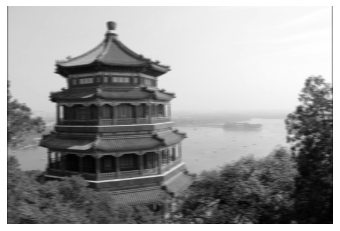

In [5]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
# 
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
# set of filters to apply - 2 7x7 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

In [6]:
# old pillow
import PIL
print (PIL.PILLOW_VERSION)

7.1.2


c:\users\michal\anaconda3\envs\ml-37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  This is separate from the ipykernel package so we can avoid doing imports until


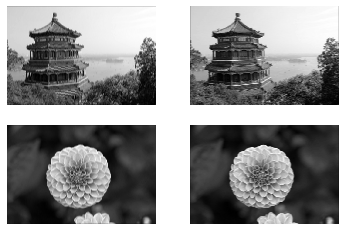

In [7]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [8]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


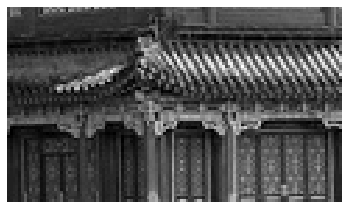

Saving figure china_vertical


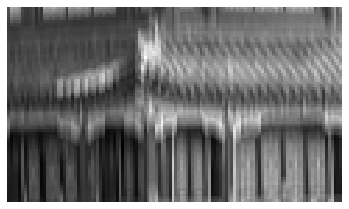

Saving figure china_horizontal


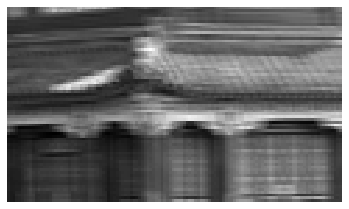

In [9]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()


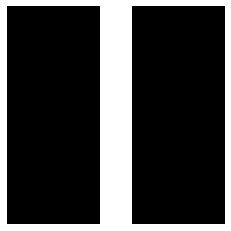

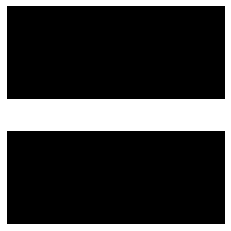

In [10]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()


### Convolutional Layer

In [11]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

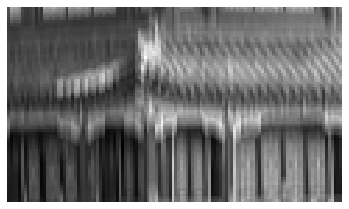

In [12]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

## VALID vs SAME padding

In [13]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [14]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [15]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

"SAME" padding - conv layer uses zero padding if necessary.
Output size is #input neurons / stride, rouded up
"VALID" padding - conv layer does not use padding, some rows & columns may be ignored

In [16]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())



## Pooling layer

### Max pooling

In [17]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [18]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


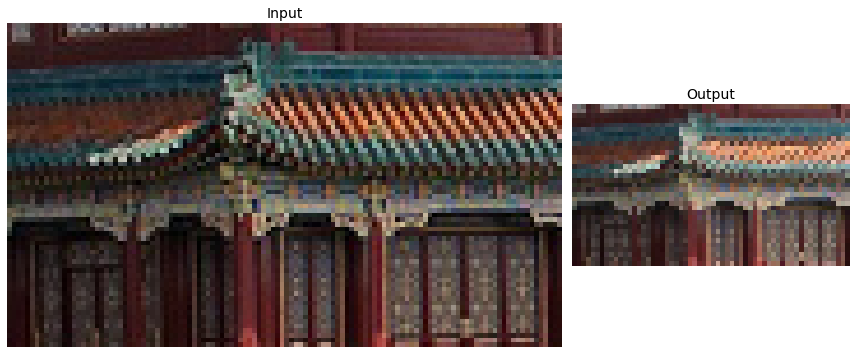

In [19]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()


In [20]:
# For average pooling - use AvgPool2D
avg_pool = keras.layers.AvgPool2D(pool_size=2)

### Depth-wise pooling

In [21]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [22]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape, cropped_images.shape


(TensorShape([2, 70, 120, 1]), (2, 70, 120, 3))

But for a 3D filter and most convolutions in deep learning, a filter is a collection of kernels


In [23]:
# or just use Lambda layer:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

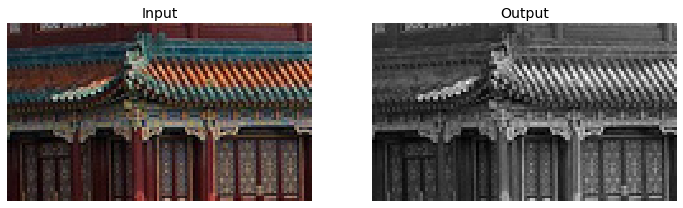

In [24]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

### Average pooling

In [25]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [26]:
output_avg = avg_pool(cropped_images)

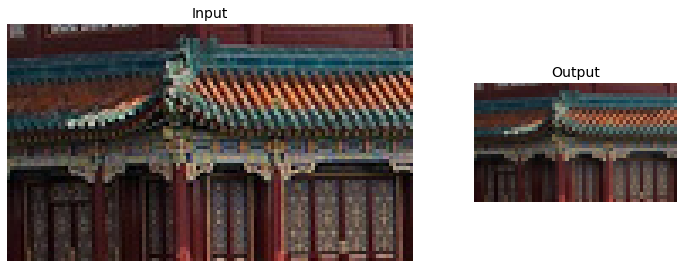

In [27]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Global Average Pooling
computes average over entire pooling layer

In [28]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

In [29]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

## Fashion MNIST With a CNN

In [30]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [31]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation="relu", padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])


In [32]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         1

In [33]:
from datetime import datetime
logdir = os.path.join(os.curdir, "my_logs\\", "tf_fashion_mnist_convolution\\"
                    "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = keras.callbacks.TensorBoard(log_dir=logdir, 
                                             histogram_freq=1, profile_batch=10,
                                             write_graph=True, write_images=True)


In [34]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),
                   callbacks=[tensorboard_cb])
score = model.evaluate(X_test, y_test, verbose=1)

X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.7076 - accuracy: 0.7494 - val_loss: 0.3812 - val_accuracy: 0.8628
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4293 - accuracy: 0.8553 - val_loss: 0.3220 - val_accuracy: 0.8834
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3656 - accuracy: 0.8746 - val_loss: 0.2980 - val_accuracy: 0.8896
Epoch 4/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3339 - accuracy: 0.8877 - val_loss: 0.2997 - val_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3105 - accuracy: 0.8933 - val_loss: 0.2743 - val_accuracy: 0.8980
Epoch 6/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2952 - accuracy: 0.9002 - val_loss: 0.2822 - val_accuracy: 0.8956
Epoch 7/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2823 - accuracy: 0.9041 - val_loss: 0.2765 -

### ResNet-34

In [35]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                               padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                               padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                               padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [36]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
    
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

### Using a Pretrained Model

In [38]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

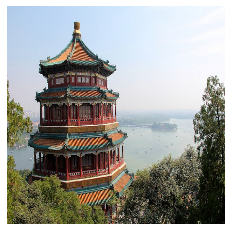

In [39]:
# resize images since resnet50 expects 224x224
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


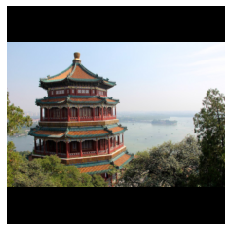

In [40]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

(2, 224, 224, 3)


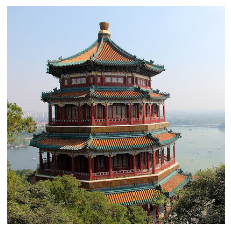

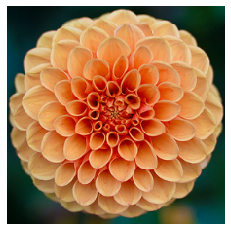

In [41]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
print(images_resized.shape)
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()


In [42]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)
Y_proba.shape

(2, 1000)

In [43]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
#top_K = model.decode_predictions(Y_proba, top=3)

for image_index in range(len(images)):
    print(f'Image #{image_index}')
    #print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



### Pretrained Models for Transfer Learning

In [12]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [13]:
info.splits, info.splits["train"]

({'train': <tfds.core.SplitInfo num_examples=3670>},
 <tfds.core.SplitInfo num_examples=3670>)

In [14]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [15]:
n_classes = info.features["label"].num_classes

In [16]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [17]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

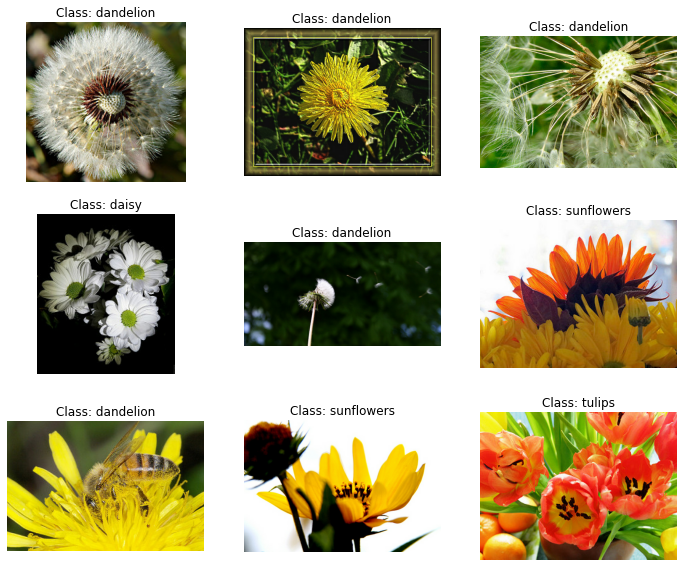

In [18]:
#example images from tdfs dataset
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [19]:
#Basic preprocessing:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [20]:
#more fancy preprocessing & data augmentation:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [21]:
from functools import partial
batch_size = 4
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

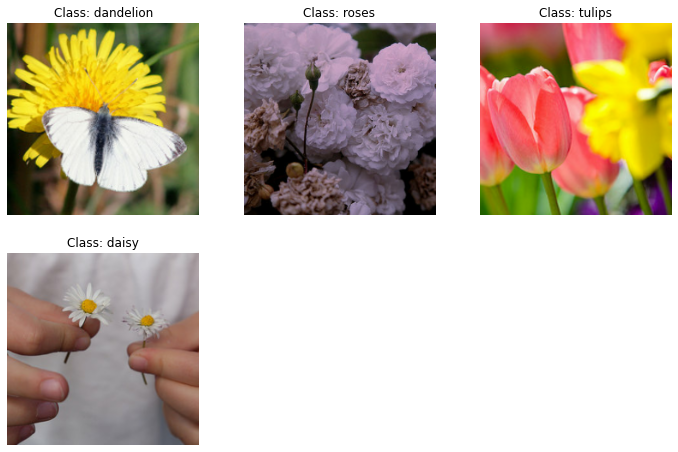

In [22]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(min(9, batch_size)):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()



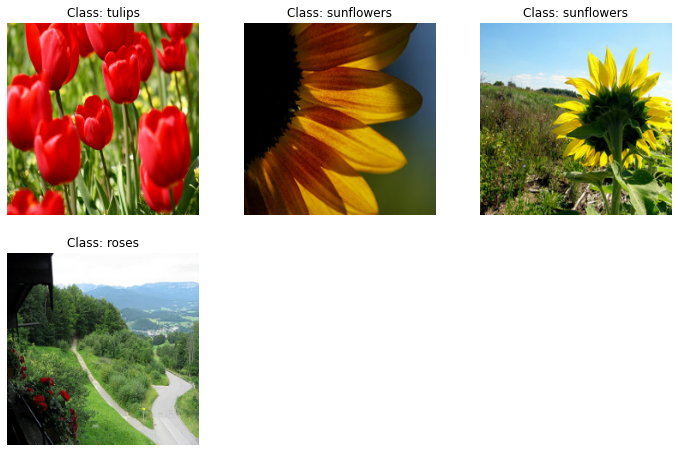

In [23]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(min(9, batch_size)):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()


In [24]:
# load xception model, take some layers off top and train it
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)


In [60]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_4
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_15
13 block2_pool
14 batch_normalization_12
15 add_36
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_16
23 block3_pool
24 batch_normalization_13
25 add_37
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_17
33 block4_pool
34 batch_normalization_14
35 add_38
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_39
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [65]:
# at the beginning - freeze all layers for base model.
for layer in base_model.layers:
    layer.trainable = False
    
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, 
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)


Train for 688 steps, validate for 137 steps
Epoch 1/5
688/688 [==============================] - 31s 45ms/step - loss: 2.6881 - accuracy: 0.6613 - val_loss: 3.3995 - val_accuracy: 0.7427
Epoch 2/5
688/688 [==============================] - 28s 40ms/step - loss: 1.3549 - accuracy: 0.7511 - val_loss: 2.6502 - val_accuracy: 0.7628
Epoch 3/5
688/688 [==============================] - 28s 40ms/step - loss: 1.1333 - accuracy: 0.7478 - val_loss: 2.3948 - val_accuracy: 0.7737
Epoch 4/5
688/688 [==============================] - 28s 40ms/step - loss: 1.0554 - accuracy: 0.7544 - val_loss: 2.1755 - val_accuracy: 0.7701
Epoch 5/5
688/688 [==============================] - 28s 40ms/step - loss: 0.8807 - accuracy: 0.7773 - val_loss: 1.9690 - val_accuracy: 0.7828


In [66]:
modelname="transfer_learning_Xception_14_model.h5"
model.save(modelname)

In [68]:
for layer in base_model.layers:
    layer.trainable = True

modelname="transfer_learning_Xception_14_model.h5"
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(modelname, save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]
    
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", "loss"])
history = model.fit(train_set, 
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40,
                    callbacks=callbacks)


Train for 688 steps, validate for 137 steps
Epoch 1/40
688/688 [==============================] - 116s 169ms/step - loss: 0.3440 - accuracy: 0.8852 - val_loss: 0.4060 - val_accuracy: 0.8631
Epoch 2/40
688/688 [==============================] - 110s 159ms/step - loss: 0.2247 - accuracy: 0.9270 - val_loss: 0.2762 - val_accuracy: 0.8905
Epoch 3/40
688/688 [==============================] - 109s 158ms/step - loss: 0.1363 - accuracy: 0.9571 - val_loss: 0.2923 - val_accuracy: 0.9124
Epoch 4/40
688/688 [==============================] - 108s 157ms/step - loss: 0.0923 - accuracy: 0.9717 - val_loss: 0.2767 - val_accuracy: 0.9197
Epoch 5/40
688/688 [==============================] - 108s 157ms/step - loss: 0.0718 - accuracy: 0.9775 - val_loss: 0.3453 - val_accuracy: 0.9015
Epoch 6/40
688/688 [==============================] - 110s 160ms/step - loss: 0.0641 - accuracy: 0.9775 - val_loss: 0.2733 - val_accuracy: 0.9161
Epoch 7/40
688/688 [==============================] - 109s 158ms/step - loss: 0.

InternalError: GPU sync failed

In [69]:
model.load(modelname)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(modelname, save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]
    
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", "loss"])
history = model.fit(train_set, 
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40,
                    callbacks=callbacks)


AttributeError: 'Model' object has no attribute 'load'